# 问题描述

分别在 `digits` 和 `20newsgroups` 两个数据集上做以下聚类算法：

* K-Means
* Affinity propagation
* Mean-shift
* Spectral clustering
* Ward hierarchical clustering
* Agglomerative clustering
* DBSCAN
* Gaussian mixtures

并按照以下评估标准进行评估：

- **Normalized Mutual Information** (NMI) 归一化互信息
    - `metrics.normalized_mutual_info_score(labels_true, labels_pred)`
- **Homogeneity**: each cluster contains only members of a single class 每个集群只包含一个类的成员
    - `metrics.homogeneity_score(labels_true, labels_pred)`
- **Completeness**: all members of a given class are assigned to the same cluster 给定类的所有成员都被分配到同一个集群
    - `metrics.completeness_score(labels_true, labels_pred)`

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn import cluster
from sklearn import datasets
from sklearn import metrics
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import scale

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# 数据集
## Digits 数据集

In [2]:
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


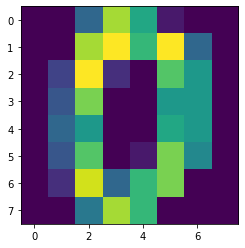

In [3]:
# print('target_names:', digits.target_names)
# print('target:', digits.target[0])
# print('images:', digits.images[0])
# print('data:', digits.data[0])
plt.imshow(digits.images[0])

## 20newsgroups 数据集

In [4]:
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

news = datasets.fetch_20newsgroups(subset='all', categories=categories,
                                   shuffle=True, random_state=42)
print(news.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [5]:
# print('target_names:', news.target_names)
# print('\ntarget:', news.target[0])
# print('\nfilenames:', news.filenames[0])
# print('\ndata:', news.data[0])

# 聚类算法

## 评估对比函数

In [6]:
def evaluate(labels_true, labels_pred, name):
    print('%-20s\t%.3f\t%.3f\t%.3f' % (
          name,
          metrics.v_measure_score(labels_true, labels_pred),
          metrics.homogeneity_score(labels_true, labels_pred),
          metrics.completeness_score(labels_true, labels_pred),
         ))

## Digits 聚类

In [16]:
X = scale(digits.data)  # 载入digits数据
x_compress = PCA(n_components=2).fit_transform(X)
y_true = digits.target

--------------------------------------------------
                    	NMI	Homo	Comp
K-Means             	0.690	0.670	0.712
AffinityPropagation 	0.669	0.665	0.674
MeanShift           	0.470	1.000	0.307
SpectralClustering  	0.828	0.805	0.853
Ward                	0.796	0.758	0.836
AgglomerativeClustering	0.718	0.678	0.763
DBSCAN              	0.613	0.605	0.621
GaussianMixture     	0.683	0.662	0.706
--------------------------------------------------


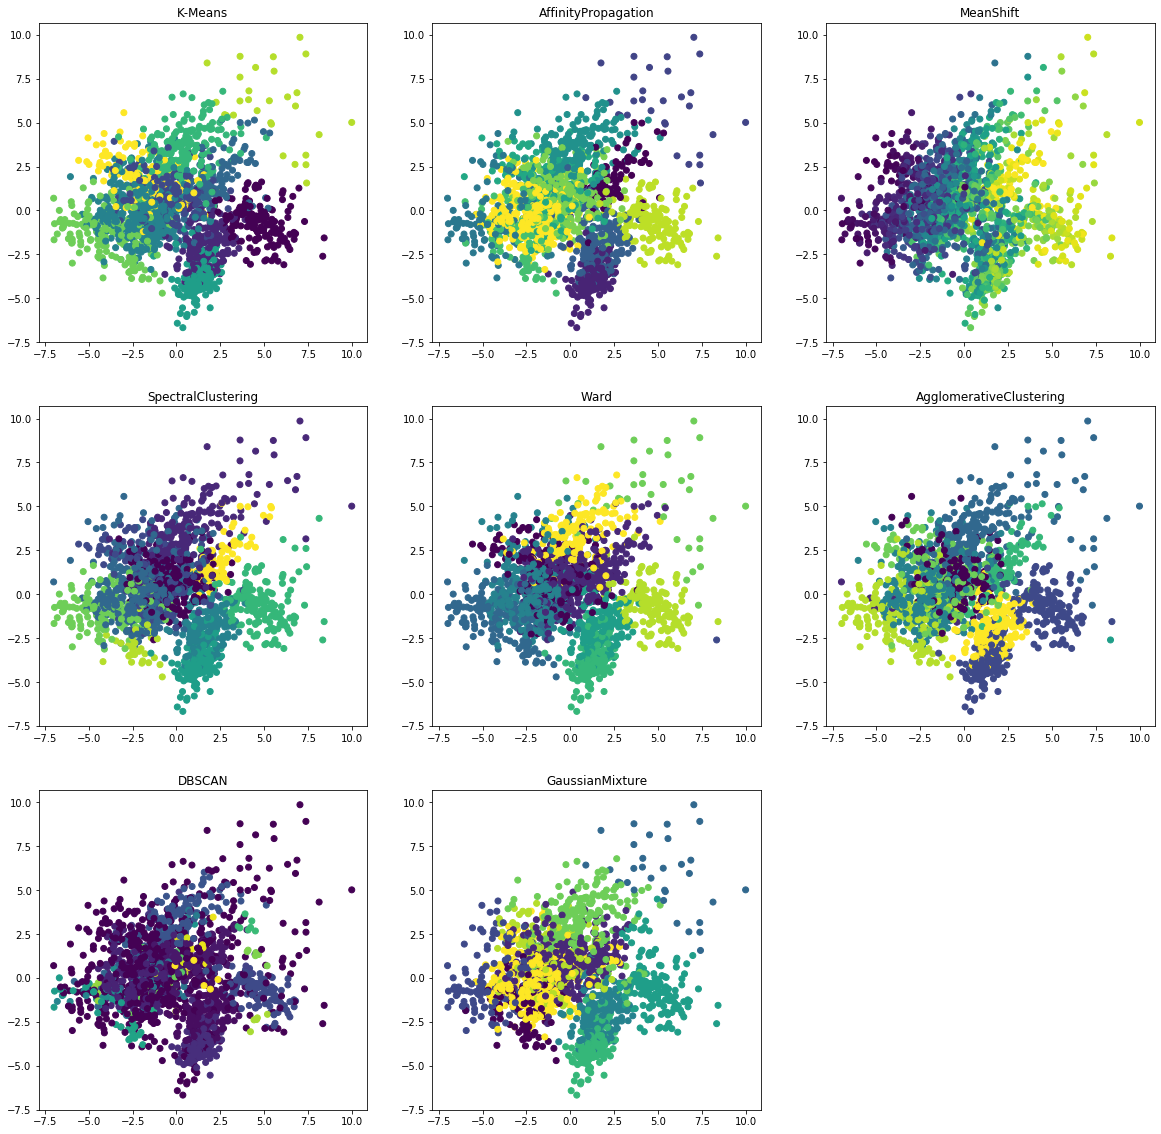

In [20]:
print('-' * 50)
print('%-20s\t%s\t%s\t%s' % ('', 'NMI', 'Homo', 'Comp'))
plt.figure(figsize=(20, 20))

y_pred = cluster.KMeans(n_clusters=10, random_state=9).fit_predict(X)
evaluate(y_true, y_pred, 'K-Means')
plt.subplot(331).set_title('K-Means')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AffinityPropagation(damping=0.88, preference=-3000).fit_predict(X)
evaluate(y_true, y_pred, 'AffinityPropagation')
plt.subplot(332).set_title('AffinityPropagation')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.MeanShift(bandwidth=1).fit_predict(X)
evaluate(y_true, y_pred, 'MeanShift')
plt.subplot(333).set_title('MeanShift')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.SpectralClustering(n_clusters=10, 
                                    affinity='nearest_neighbors').fit_predict(X)
evaluate(y_true, y_pred, 'SpectralClustering')
plt.subplot(334).set_title('SpectralClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(X)
evaluate(y_true, y_pred, 'Ward')
plt.subplot(335).set_title('Ward')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AgglomerativeClustering(n_clusters=10, linkage='average', 
                                         affinity='cosine').fit_predict(X)
evaluate(y_true, y_pred, 'AgglomerativeClustering')
plt.subplot(336).set_title('AgglomerativeClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.DBSCAN(eps=4, min_samples=4).fit_predict(X)
evaluate(y_true, y_pred, 'DBSCAN')
plt.subplot(337).set_title('DBSCAN')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = mixture.GaussianMixture(n_components=10).fit_predict(X)
evaluate(y_true, y_pred, 'GaussianMixture')
plt.subplot(338).set_title('GaussianMixture')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

print('-' * 50)
plt.show()

## 20newsgroups 聚类

In [9]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(news.data)
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
x_compress = PCA(n_components=2).fit_transform(X)
y_true = news.target
true_k = np.unique(y_true).shape[0]

--------------------------------------------------
                    	NMI	Homo	Comp
K-Means             	0.441	0.439	0.442
AffinityPropagation 	0.289	1.000	0.169
MeanShift           	0.267	0.893	0.157
SpectralClustering  	0.478	0.442	0.521
Ward                	0.442	0.439	0.446
AgglomerativeClustering	0.469	0.419	0.532
DBSCAN              	0.430	0.423	0.437
GaussianMixture     	0.432	0.432	0.433
--------------------------------------------------


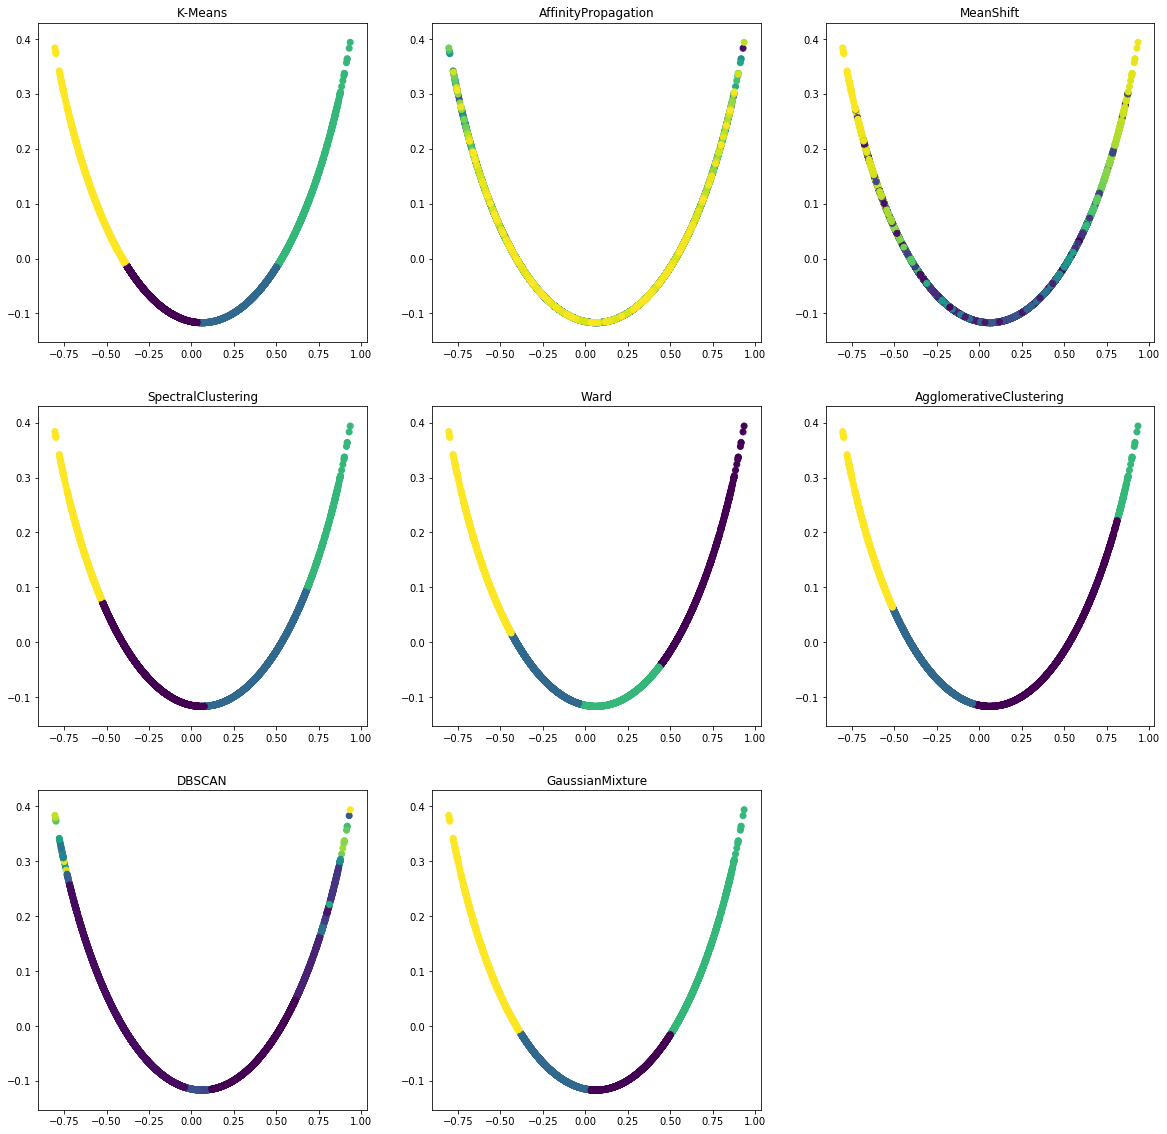

In [10]:
print('-' * 50)
print('%-20s\t%s\t%s\t%s' % ('', 'NMI', 'Homo', 'Comp'))
plt.figure(figsize=(20, 20))

y_pred = cluster.KMeans(n_clusters=true_k, random_state=9).fit_predict(X)
evaluate(y_true, y_pred, 'K-Means')
plt.subplot(331).set_title('K-Means')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AffinityPropagation(damping=0.88, preference=-3000).fit_predict(X)
evaluate(y_true, y_pred, 'AffinityPropagation')
plt.subplot(332).set_title('AffinityPropagation')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.MeanShift(bandwidth=0.0001, bin_seeding=True).fit_predict(X)
evaluate(y_true, y_pred, 'MeanShift')
plt.subplot(333).set_title('MeanShift')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.SpectralClustering(n_clusters=true_k).fit_predict(X)
evaluate(y_true, y_pred, 'SpectralClustering')
plt.subplot(334).set_title('SpectralClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AgglomerativeClustering(n_clusters=true_k, 
                                         linkage='ward').fit_predict(X)
evaluate(y_true, y_pred, 'Ward')
plt.subplot(335).set_title('Ward')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AgglomerativeClustering(n_clusters=true_k, 
                                         linkage='average',
                                         affinity='manhattan').fit_predict(X)
evaluate(y_true, y_pred, 'AgglomerativeClustering')
plt.subplot(336).set_title('AgglomerativeClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.DBSCAN(eps=0.004, min_samples=1).fit_predict(X)
evaluate(y_true, y_pred, 'DBSCAN')
plt.subplot(337).set_title('DBSCAN')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = mixture.GaussianMixture(n_components=true_k).fit_predict(X)
evaluate(y_true, y_pred, 'GaussianMixture')
plt.subplot(338).set_title('GaussianMixture')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

print('-' * 50)
plt.show()

# 附

## 【转】各聚类算法效果图

![](http://img.qingtingip.com/crawler/article/2019514/e7232fd2c86616b9a41c73c19ff97326)